# How to include biological information into hyperdimensional vectors and is this useful?

include("../src/HDC.jl")
include("../src/math.jl")
include("../src/experimental.jl")
using DataFrames
using CSV
using JLD

## Method 1: Via embeddings (ESM-2)

In [2]:
#Load embeddings from last hidden layer of ESM-2 model (21x1280)
aa_embeddings = DataFrame(CSV.File("../data/amino_acid_embeddings.csv"))
amino_acids_esm = aa_embeddings.protein_ID
aa_emb = Matrix(aa_embeddings[:, 2:end])
# Create HDVs
HDV_mat_bit = nested_arrays2mat([bithdv() for i in 1:size(aa_emb)[2]], true)

# Extend embeddings into hyperdimensional space
AA_bit_esm = permutedims(mat_scaler(aa_emb * HDV_mat_bit, 0, 1, 2) .|> round)

10000×21 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0  1.0  1.0  0.0  1.0  1.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0     0.0  0.0  0.0  1.0  1.0  0.0  1.0
 0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0     1.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  1.0  1.0  1.0
 0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0     1.0  0.0  0.0  0.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0     1.0  0.0  1.0  1.0  0.0  0.0  1.0
 ⋮                        ⋮              ⋱       ⋮                        ⋮
 1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0     0.0  1.0  0.0  0.0  0.0  1.0  1.0
 0.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0 

## Baseline random HDVs

In [3]:
rand_bit = nested_arrays2mat([bithdv() for i in 1:20], true)

20×10000 BitMatrix:
 1  0  0  0  1  1  1  1  0  1  1  0  1  …  0  1  1  0  1  0  0  1  1  0  1  1
 0  1  1  1  1  1  1  1  1  1  1  0  0     0  0  0  1  1  0  0  0  1  1  1  1
 0  1  0  0  1  0  1  0  1  1  0  0  0     0  0  0  0  1  1  1  0  0  0  1  0
 1  0  0  0  1  0  0  1  0  1  0  1  1     1  0  1  1  0  0  0  0  0  1  0  0
 1  1  0  0  0  1  1  1  1  0  0  1  0     0  1  0  1  1  1  0  1  0  1  1  1
 0  1  1  1  1  0  0  0  0  1  1  0  1  …  0  0  1  0  1  1  1  1  0  1  0  1
 1  1  0  0  1  1  0  0  0  1  0  0  1     0  0  0  0  1  0  1  0  0  0  1  0
 0  0  1  1  0  0  1  0  0  1  1  1  1     0  1  0  1  0  1  0  0  1  1  1  0
 0  0  1  0  0  1  1  0  0  1  1  1  1     0  0  1  0  1  1  0  1  0  0  0  1
 0  0  1  1  0  0  0  0  0  1  1  0  1     1  0  0  0  0  0  0  1  1  1  1  0
 0  0  1  1  1  1  0  0  0  1  1  1  1  …  0  0  1  1  0  0  1  1  0  0  0  0
 0  0  1  0  0  1  0  1  1  1  0  1  0     1  1  0  1  1  1  1  1  1  1  1  0
 1  1  1  0  0  0  0  0  1  0  1  0  0     1

## PCA plots: is the physicochemical and biological information encoded into the HDVs?
### Binary HDVs

In [4]:
using MultivariateStats

PCA_rand_bit = fit(PCA, rand_bit; maxoutdim=2)
proj_rand_bit = projection(PCA_rand_bit)

PCA_ESM_bit = fit(PCA, AA_bit_esm; maxoutdim=2)
proj_ESM_bit = projection(PCA_ESM_bit)

groups = Dict("polar" => ['S', 'T', 'Y', 'N', 'Q'], "non-polar" => ['G', 'A', 'V', 'C', 'P', 'L', 'I', 'M', 'W', 'F'], 
         "pos+" => ['L', 'R', 'H'], "neg-" => ['D', 'E'])

Dict{String, Vector{Char}} with 4 entries:
  "non-polar" => ['G', 'A', 'V', 'C', 'P', 'L', 'I', 'M', 'W', 'F']
  "polar"     => ['S', 'T', 'Y', 'N', 'Q']
  "pos+"      => ['L', 'R', 'H']
  "neg-"      => ['D', 'E']

In [5]:
PCA_rand_bit

PCA(indim = 20, outdim = 2, principalratio = 0.10637099803737807)

Pattern matrix (unstandardized loadings):
────────────────────────────
            PC1          PC2
────────────────────────────
1   -0.174226    -0.0272715
2   -0.029327    -0.0188189
3    0.151223    -0.0978606
4   -0.0766266    0.190342
5    0.192401     0.0951709
6   -0.00706651   0.0586796
7    0.0466176    0.119026
8   -0.0865768    0.0272525
9    0.124899    -0.187457
10   0.22212      0.0144928
11  -0.0959379   -0.209349
12   0.126499    -0.0391278
13  -0.112683    -0.0494708
14  -0.0388657   -0.00731054
15  -0.00267756  -0.0516445
16   0.18644      0.024705
17   0.00532832  -0.0508257
18  -0.0895028    0.0214618
19   0.0610195    0.267854
20  -0.0978637    0.17066
────────────────────────────

Importance of components:
───────────────────────────────────────────────
                                 PC1        PC2
───────────────────────────────────────────────
SS Loadings (Eigenvalues)  0.26715    0.264716
Vari

In [6]:
PCA_ESM_bit

PCA(indim = 10000, outdim = 2, principalratio = 0.2230726900503387)

Pattern matrix (unstandardized loadings):
─────────────────────────────────
                PC1           PC2
─────────────────────────────────
1       0.124837     -0.225132
2       0.143292      0.0484261
3       0.151901     -0.196108
4       0.146035      0.0194125
5      -0.0534589     0.00337249
6       0.0667114    -0.35788
7      -0.0524815    -0.12508
8       0.252214      0.277004
9       0.11462      -0.19439
10     -0.117925      0.283323
11      0.114686     -0.182506
12      0.306535     -0.0354467
13      0.0146128     0.139682
14     -0.215938     -0.104162
15      0.16849      -0.140647
16     -0.0883211     0.0995513
17      0.144844      0.112961
18      0.0437957    -0.179383
19      0.12965      -0.0382895
20      0.30595      -0.0149853
21     -0.129199      0.128843
22      0.117519      0.169023
23      0.113065     -0.207412
24      0.14984       0.0709154
25     -0.0172155     0.0137419
26   

In [7]:
proj_rand_bit

20×2 Matrix{Float64}:
 -0.337082     0.0530052
 -0.05674      0.0365766
  0.292578     0.190203
 -0.148252    -0.369951
  0.372247    -0.184976
 -0.0136719   -0.11405
  0.090193    -0.231341
 -0.167504    -0.0529683
  0.241646     0.364343
  0.429744    -0.0281684
 -0.185615     0.406893
  0.244743     0.0760493
 -0.218013     0.0961522
 -0.0751949    0.0142089
 -0.00518039   0.100377
  0.360713    -0.048017
  0.0103089    0.0987856
 -0.173165    -0.0417135
  0.118057    -0.520604
 -0.189341    -0.331697

#### Random binary HDVs

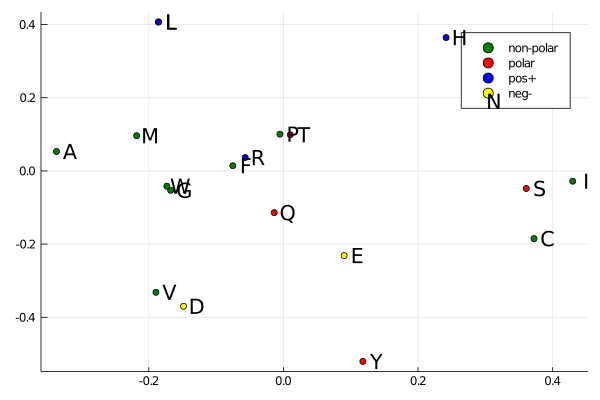

In [16]:
using Plots
AA_list = AA_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'O', 'U', 'B', 'J', 'Z']
key = collect(keys(groups))
indices = [[i for i in 1:length(AA_list) if AA_list[i] in groups[j]] for j in key]
AA_ind = [[i for i in AA_list if i in groups[j]] for j in key]

colors = [:green, :red, :blue, :yellow]
fig = Plots.plot()

for i in 1:4
    scatter!(fig, (proj_rand_bit[indices[i], 1], proj_rand_bit[indices[i], 2]), label=key[i], mc = colors[i])
    for j in 1:length(indices[i])
        annotate!((proj_rand_bit[indices[i][j], 1] + 0.02, proj_rand_bit[indices[i][j], 2], AA_ind[i][j]))
    end
end
savefig("../thesis/Fig/random_emb.png")
fig

#### ESM embedded HDVs

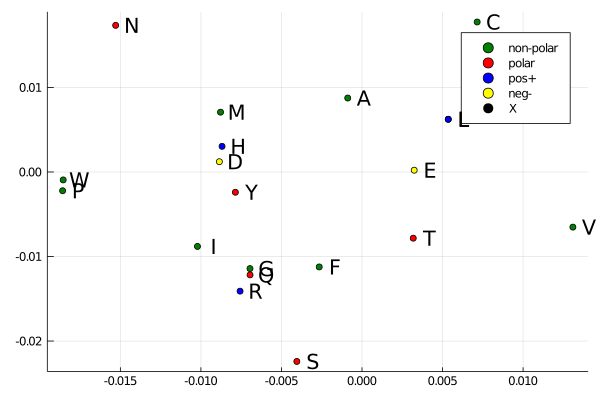

In [24]:
indices = [[i for i in 1:length(amino_acids_esm) if only(amino_acids_esm[i]) in groups[j]] for j in key]
AA_ind = [[only(i) for i in amino_acids_esm if only(i) in groups[j]] for j in key]

colors = [:green, :red, :blue, :yellow]
fig = Plots.plot()

for i in 1:4
    scatter!(fig, (proj_ESM_bit[indices[i], 1], proj_ESM_bit[indices[i], 2]), label=key[i], mc = colors[i])
    for j in 1:length(indices[i])
        annotate!((proj_ESM_bit[indices[i][j], 1] + 0.001, proj_ESM_bit[indices[i][j], 2], AA_ind[i][j]))
    end
end
scatter!(fig, (proj_ESM_bit[21, 1], proj_ESM_bit[21, 2]), label="X", mc = :black)
savefig("../thesis/Fig/esm_emb.png")
fig

In [19]:
amino_acids_esm

21-element Vector{String1}:
 "R"
 "H"
 "K"
 "D"
 "E"
 "S"
 "T"
 "N"
 "Q"
 "C"
 ⋮
 "A"
 "V"
 "I"
 "L"
 "M"
 "F"
 "Y"
 "W"
 "X"

# Human ref proteome embeddings

In [26]:
using JLD
dict4 = load("/home/mfat/Master-Thesis/data/aa_hdv_dict4.jld")["aa_hdv_dict"]
dictk = load("/home/mfat/Master-Thesis/data/aa_hdv_dictk.jld")["aa_hdv_dict"]

Dict{Any, Any} with 22 entries:
  'E' => [0.352386, 0.590637, 0.327424, 0.616646, 0.284433, 0.592283, 0.293631,…
  'X' => [0.208955, 0.283582, 0.492537, 0.402985, 0.656716, 0.298507, 0.701493,…
  'C' => [0.5521, 0.319237, 0.319367, 0.612369, 0.647701, 0.31536, 0.646171, 0.…
  'D' => [0.342342, 0.60075, 0.317189, 0.298431, 0.277138, 0.318302, 0.635705, …
  'A' => [0.355902, 0.589281, 0.329606, 0.609236, 0.630783, 0.334907, 0.620733,…
  'R' => [0.352595, 0.596882, 0.59478, 0.611755, 0.288304, 0.323442, 0.625463, …
  'G' => [0.347911, 0.328428, 0.597221, 0.307066, 0.63524, 0.326429, 0.299178, …
  'Q' => [0.353907, 0.590544, 0.323333, 0.312928, 0.636032, 0.324199, 0.628516,…
  'N' => [0.330291, 0.312455, 0.307171, 0.288853, 0.657438, 0.305346, 0.273399,…
  'P' => [0.36618, 0.583907, 0.583986, 0.590962, 0.297042, 0.572822, 0.608984, …
  'K' => [0.341694, 0.316981, 0.604161, 0.291194, 0.647932, 0.305101, 0.647397,…
  'M' => [0.578948, 0.312314, 0.606429, 0.293712, 0.648803, 0.31177, 0.6376, 

In [27]:
mat4 = collect(values(dict4))
mat4 = nested_arrays2mat(mat4, true)

mat50 = collect(values(dictk))
mat50 = nested_arrays2mat(mat50, true)


AA_list4 = collect(keys(dict4))
AA_list50 = collect(keys(dictk))
groups = Dict("polar" => ['S', 'T', 'Y', 'N', 'Q'], "non-polar" => ['G', 'A', 'V', 'C', 'P', 'L', 'I', 'M', 'W', 'F'], 
         "pos+" => ['L', 'R', 'H'], "neg-" => ['D', 'E'], "ambiguous" => ['U', 'X'])

Dict{String, Vector{Char}} with 5 entries:
  "non-polar" => ['G', 'A', 'V', 'C', 'P', 'L', 'I', 'M', 'W', 'F']
  "polar"     => ['S', 'T', 'Y', 'N', 'Q']
  "pos+"      => ['L', 'R', 'H']
  "neg-"      => ['D', 'E']
  "ambiguous" => ['U', 'X']

In [28]:
using MultivariateStats

PCA_tr4 = fit(PCA, mat4; maxoutdim=2)
PCA_tr50 = fit(PCA, mat50; maxoutdim=2)

PCA(indim = 22, outdim = 2, principalratio = 0.20964585932349752)

Pattern matrix (unstandardized loadings):
────────────────────────────
            PC1          PC2
────────────────────────────
1    0.0337462   -0.0528073
2    0.042781     0.00227248
3    0.014668    -0.0375495
4    0.0364915   -0.0317672
5   -0.0195139   -0.0643319
6    0.0364856   -0.00106072
7    0.0766356   -0.0307495
8    0.066927    -0.00510404
9    0.0629037    0.0617347
10   0.0836329   -0.0247597
11   0.0587453    0.0716219
12   0.00106795   0.0120319
13  -0.00971746   0.0675031
14   0.00904653   0.0830463
15   0.0557034   -0.0181724
16   0.0733398    7.36789e-5
17   0.0652103   -0.0297473
18   0.0474563   -0.0372422
19  -0.0079552   -0.0081835
20   0.046229     0.0321628
21   0.0111487    0.0593225
22  -0.0441597   -0.0282788
────────────────────────────

Importance of components:
───────────────────────────────────────────────
                                 PC1        PC2
────────────────────────────────

In [33]:
PCA_tr4 = fit(PCA, mat4; maxoutdim=2)

PCA(indim = 22, outdim = 2, principalratio = 0.20874373050449502)

Pattern matrix (unstandardized loadings):
────────────────────────────
            PC1          PC2
────────────────────────────
1    0.0340219   -0.0535142
2    0.0686751    0.0400868
3    0.0182164   -0.0323296
4    0.0491864   -0.0204048
5   -0.0120143   -0.0511111
6    0.0388999    0.00346075
7    0.070001    -0.0419041
8    0.0677659    0.00371946
9    0.0625773    0.0519827
10   0.0798455   -0.0330346
11   0.0564447    0.0713107
12   0.0121978    0.0177812
13  -0.00364271   0.0722949
14   0.0137072    0.0787965
15   0.047268    -0.0186065
16   0.0670046   -0.0182353
17   0.0681696   -0.0322752
18   0.0452112   -0.0405153
19   0.00758924  -0.0066712
20   0.0453341    0.0282813
21   0.0216614    0.061358
22  -0.0343776   -0.0142983
────────────────────────────

Importance of components:
───────────────────────────────────────────────
                                 PC1        PC2
───────────────────────────────────

In [34]:
PCA_tr50 = fit(PCA, mat50; maxoutdim=2)

PCA(indim = 22, outdim = 2, principalratio = 0.20964585932349752)

Pattern matrix (unstandardized loadings):
────────────────────────────
            PC1          PC2
────────────────────────────
1    0.0337462   -0.0528073
2    0.042781     0.00227248
3    0.014668    -0.0375495
4    0.0364915   -0.0317672
5   -0.0195139   -0.0643319
6    0.0364856   -0.00106072
7    0.0766356   -0.0307495
8    0.066927    -0.00510404
9    0.0629037    0.0617347
10   0.0836329   -0.0247597
11   0.0587453    0.0716219
12   0.00106795   0.0120319
13  -0.00971746   0.0675031
14   0.00904653   0.0830463
15   0.0557034   -0.0181724
16   0.0733398    7.36789e-5
17   0.0652103   -0.0297473
18   0.0474563   -0.0372422
19  -0.0079552   -0.0081835
20   0.046229     0.0321628
21   0.0111487    0.0593225
22  -0.0441597   -0.0282788
────────────────────────────

Importance of components:
───────────────────────────────────────────────
                                 PC1        PC2
────────────────────────────────

In [29]:
proj_tr4 = projection(PCA_tr4)
proj_tr50 = projection(PCA_tr50)

22×2 Matrix{Float64}:
  0.150287   -0.265707
  0.190523    0.0114343
  0.0653229  -0.188935
  0.162513   -0.159841
 -0.086904   -0.323695
  0.162486   -0.00533718
  0.341292   -0.15472
  0.298056   -0.0256817
  0.280138    0.310626
  0.372454   -0.124582
  ⋮          
  0.0402882   0.417858
  0.248072   -0.0914368
  0.326614    0.000370725
  0.29041    -0.149677
  0.211344   -0.187389
 -0.035428   -0.0411764
  0.205878    0.161832
  0.0496499   0.298489
 -0.196662   -0.142288

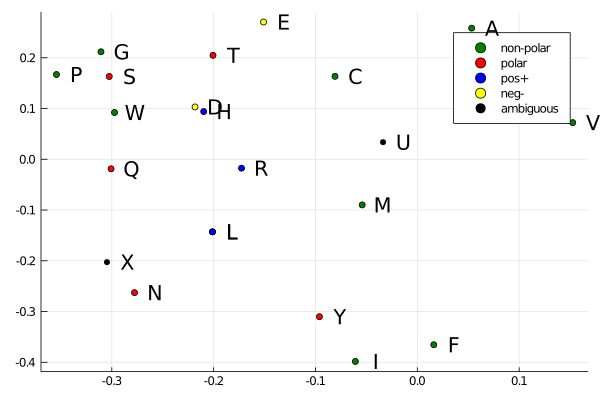

In [30]:
using Plots
groups = Dict("polar" => ['S', 'T', 'Y', 'N', 'Q'], "non-polar" => ['G', 'A', 'V', 'C', 'P', 'L', 'I', 'M', 'W', 'F'], 
         "pos+" => ['L', 'R', 'H'], "neg-" => ['D', 'E'], "ambiguous" => ['U', 'X'])
key = collect(keys(groups))
indices = [[i for i in 1:length(AA_list4) if AA_list4[i] in groups[j]] for j in key]
AA_ind = [[only(i) for i in AA_list4 if only(i) in groups[j]] for j in key]

colors = [:green, :red, :blue, :yellow, :black]
fig = Plots.plot()

for i in 1:5
    scatter!(fig, (proj_tr4[indices[i], 1], proj_tr4[indices[i], 2]), label=key[i], mc = colors[i])
    for j in 1:length(indices[i])
        annotate!((proj_tr4[indices[i][j], 1] + 0.02, proj_tr4[indices[i][j], 2], AA_ind[i][j]))
    end
end
savefig("../thesis/Fig/4tr_emb.png")
fig


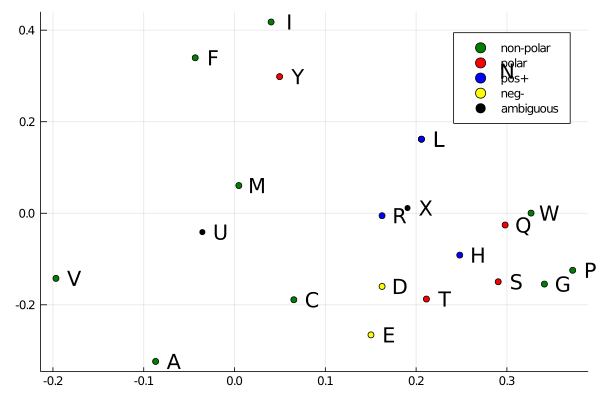

In [32]:
using Plots

key = collect(keys(groups))
indices = [[i for i in 1:length(AA_list50) if AA_list50[i] in groups[j]] for j in key]
AA_ind = [[only(i) for i in AA_list50 if only(i) in groups[j]] for j in key]

colors = [:green, :red, :blue, :yellow, :black]
fig = Plots.plot()

for i in 1:5
    scatter!(fig, (proj_tr50[indices[i], 1], proj_tr50[indices[i], 2]), label=key[i], mc = colors[i])
    for j in 1:length(indices[i])
        annotate!((proj_tr50[indices[i][j], 1] + 0.02, proj_tr50[indices[i][j], 2], AA_ind[i][j]))
    end
end
savefig("../thesis/Fig/50tr_emb.png")

fig